## Import packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# create 2D array with dimenson 54*3
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

In [3]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

## Correcting for Distortion

In [4]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

#### Test undistort function

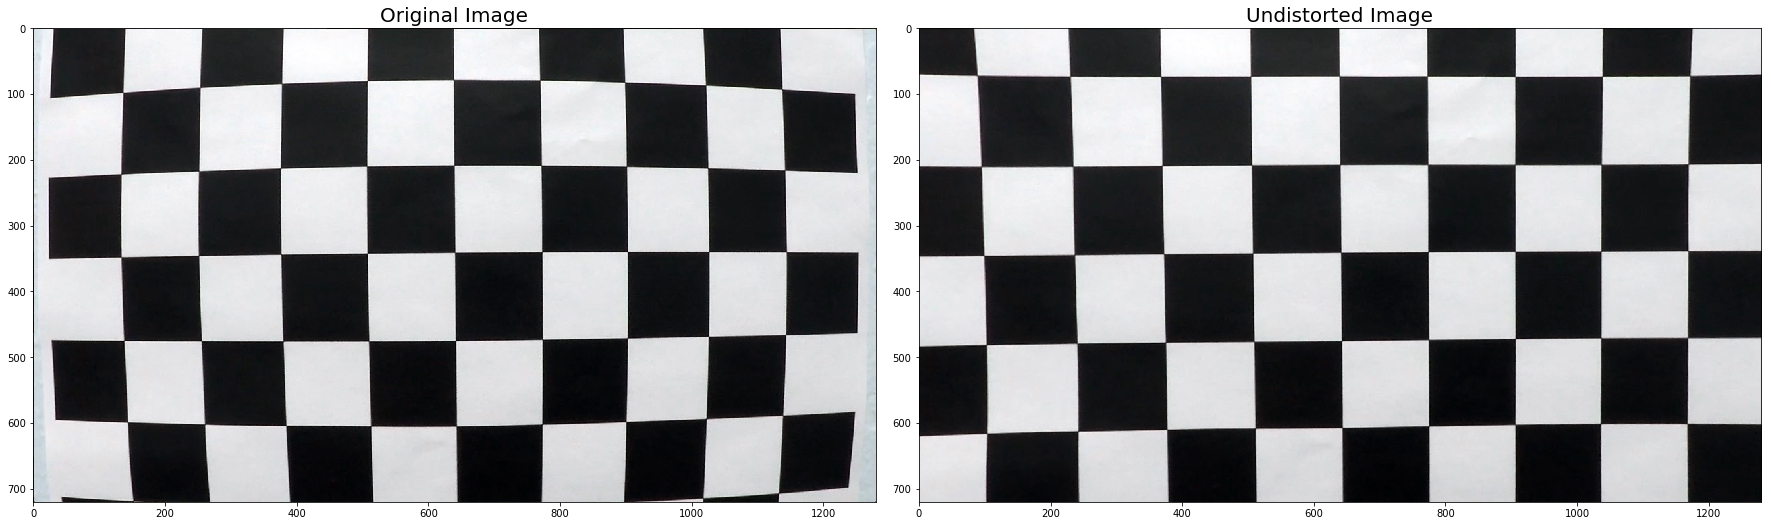

In [19]:
test_img = cv2.imread('camera_cal/calibration1.jpg')
undistored_test_img = cal_undistort(test_img, objpoints, imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistored_test_img)
ax2.set_title('Undistorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Create Thresholded Binary Image

### Grandient Thresholds

#### Sobel Grandient edge detection

In [6]:
#### A large portion of code are inspired from the Udacity SDCND lectures ####

# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

#### Test - detecting lanes based on Sobel filter

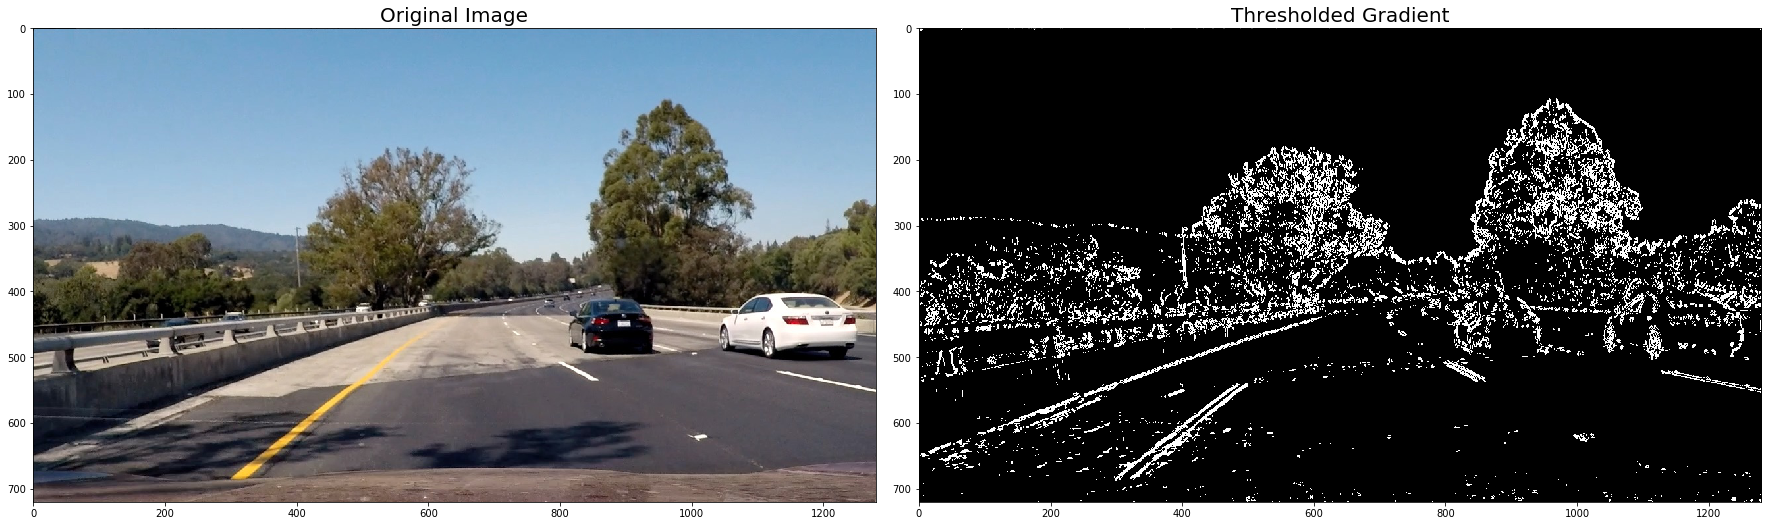

In [7]:
test_img2 = mpimg.imread('test_images/test4.jpg')
grad_x = abs_sobel_thresh(test_img2, orient='x', thresh_min=20, thresh_max=100)
mag_binary = mag_thresh(test_img2, sobel_kernel=9, mag_thresh=(30, 100))
dir_binary = dir_threshold(test_img2, sobel_kernel=15, thresh=(0.7, 1.3))

grad_binary = np.zeros_like(grad_x)
grad_binary[(grad_x == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img2)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Color Space Thresholds


#### HLS threshold

In [8]:
def hls_saturation_threshold(img, thresh_min=0, thresh_max=255):
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    return s_binary

#### Test - HLS color space binary threshold image

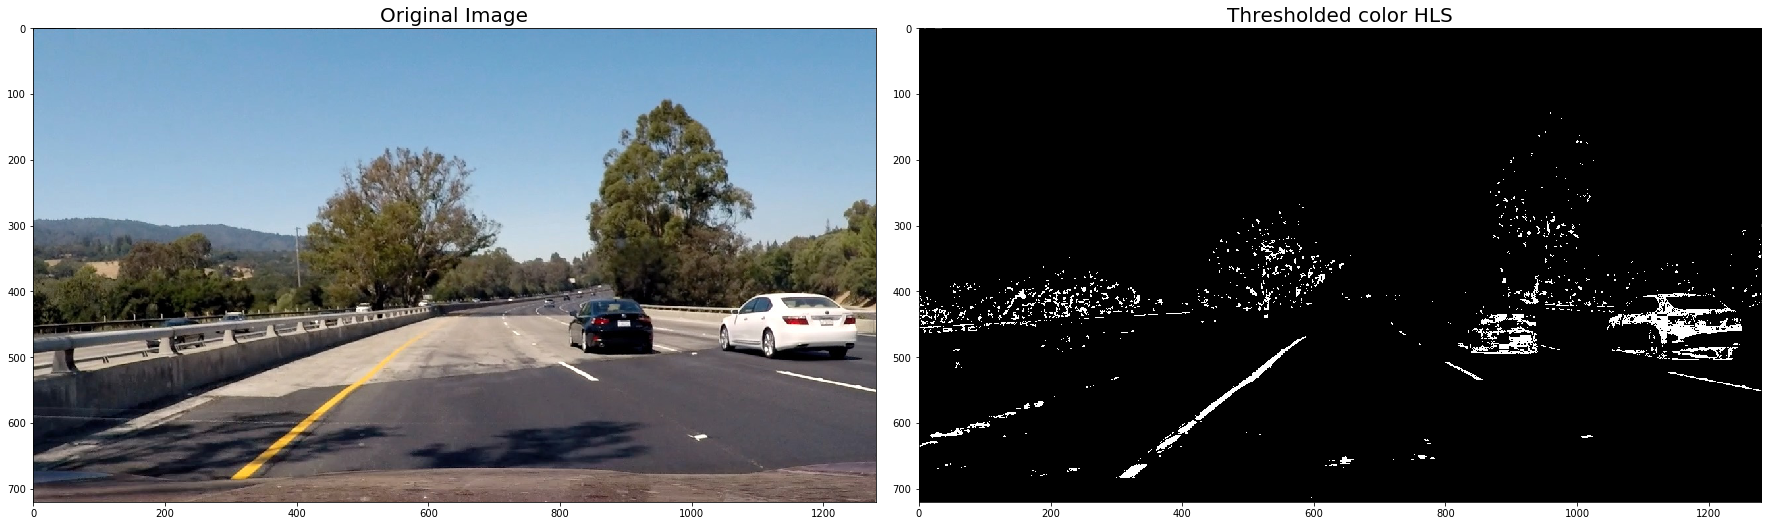

In [9]:
# Convert to HLS color space and separate the S channel
# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = hls_saturation_threshold(test_img2, s_thresh_min, s_thresh_max)
color_binary = np.zeros_like(s_binary)
color_binary[(s_binary == 1)] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img2)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(color_binary, cmap='gray')
ax2.set_title('Thresholded color HLS', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Combine Gradient and Color thresholds

In [10]:
def binary_thresholds_pipeline(img):
    grad_x = abs_sobel_thresh(img, orient='x', thresh_min=30, thresh_max=100)
    mag_binary = mag_thresh(img, sobel_kernel=9, mag_thresh=(40, 80))
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.8, 1.20))
    s_binary = hls_saturation_threshold(img, thresh_min=170, thresh_max=255)
    color_grad_binary = np.zeros_like(s_binary)
    color_grad_binary[(grad_x == 1) | ((mag_binary == 1) & (dir_binary == 1)) | (s_binary == 1) ] = 1
    return color_grad_binary

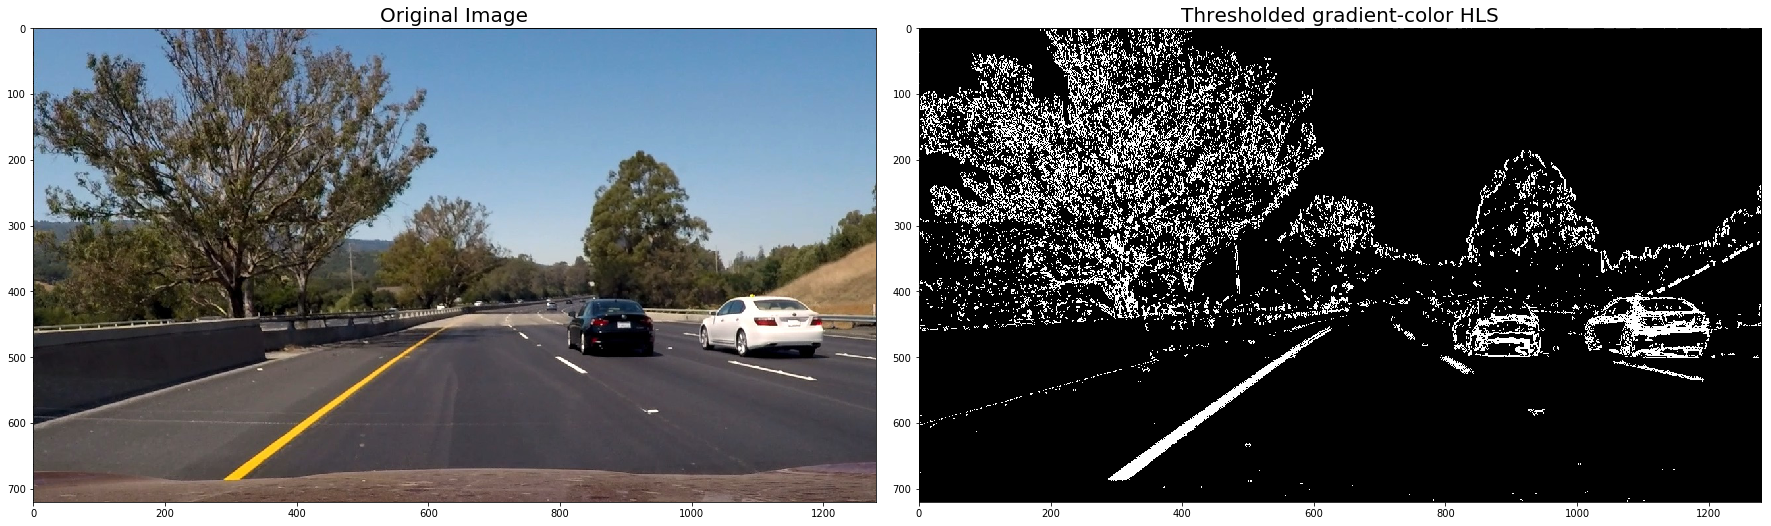

In [11]:
test_img2 = mpimg.imread('test_images/test6.jpg')
color_grad_binary = binary_thresholds_pipeline(test_img2)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img2)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(color_grad_binary, cmap='gray')
ax2.set_title('Thresholded gradient-color HLS', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Apply a perspective transform (Bird View)

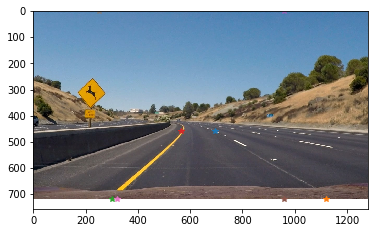

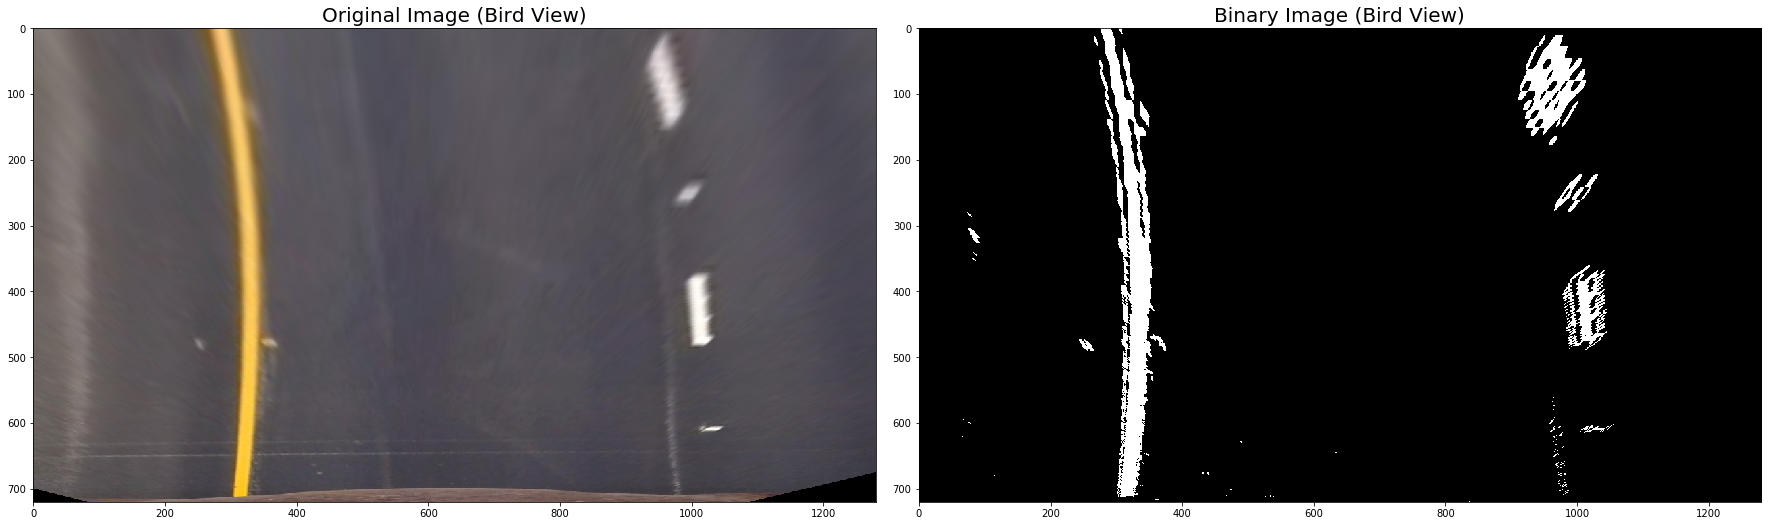

In [12]:
def perpective_trans_m():
    src = np.float32(
        [[695,460], # top right
         [1120,720], # bottom right
         #[1120,720], # bottom right
         [300,720], # bottom left
         #[200,670], # bottom left
         [565,460]]) # top left
    dst = np.float32(
        [[960,0],
         [960,720],
         [320,720],
         [250,0]])   
    M = cv2.getPerspectiveTransform(src, dst)
    return M

test_img3 = mpimg.imread('test_images/test2.jpg')
plt.imshow(test_img3)
plt.plot(695,460, "*")
plt.plot(1120,720, "*")
plt.plot(300,720, "*")
plt.plot(565,460, "*")

plt.plot(960,0, "*")
plt.plot(960,720, "*")
plt.plot(320,720, "*")
plt.plot(250,0, "*")

undistored_test_img = cal_undistort(test_img3, objpoints, imgpoints)
color_grad_binary = binary_thresholds_pipeline(undistored_test_img)


M = perpective_trans_m()
undistored_test_img_warped = cv2.warpPerspective(undistored_test_img, M, (1280,720))
color_grad_binary_warped = cv2.warpPerspective(color_grad_binary, M, (1280,720))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistored_test_img_warped)
ax1.set_title('Original Image (Bird View)', fontsize=20)
ax2.imshow(color_grad_binary_warped, cmap='gray')
ax2.set_title('Binary Image (Bird View)', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

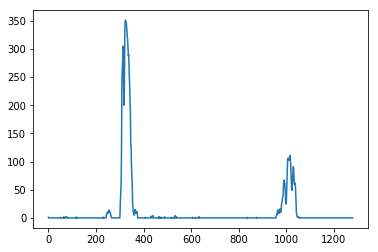

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

histogram = np.sum(color_grad_binary_warped[color_grad_binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

## Helper Functions

In [14]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def getCurvature(ploty, leftx, lefty, rightx, righty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return (left_curverad + right_curverad)/2

def offsetCenter(image, ploty, left_fit, right_fit):
    y_eval = np.max(ploty)
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    bottom_leftx = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    bottom_rightx = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    
    center_lane = (bottom_leftx + bottom_rightx)/2
    car_location = image.shape[1]/2
    return abs((center_lane - car_location)*xm_per_pix)

## Pipeline

In [15]:
from numpy.linalg import inv

def process_image(image):
    undistored_test_img = cal_undistort(image, objpoints, imgpoints)
    color_grad_binary_undistored = binary_thresholds_pipeline(undistored_test_img)
    
    # Region of interest
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(450, 330), (510, 330), (imshape[1],imshape[0])]], dtype=np.int32)
    color_grad_binary_masked = region_of_interest(color_grad_binary_undistored, vertices)
    
    M = perpective_trans_m()
    color_grad_binary_warped = cv2.warpPerspective(color_grad_binary_masked, M, (1280,720))
    
    histogram = np.sum(color_grad_binary_warped[color_grad_binary_warped.shape[0]//2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(color_grad_binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = color_grad_binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    global left_fit, right_fit
    if (left_fit, right_fit) == (None, None):
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = color_grad_binary_warped.shape[0] - (window+1)*window_height
            win_y_high = color_grad_binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    else:
        # Skip the sliding windows step once you know where the lines are
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, color_grad_binary_warped.shape[0]-1, color_grad_binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(color_grad_binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.polylines(color_warp,np.int32(pts_left), 1, (255,0,0), 50)
    cv2.polylines(color_warp,np.int32(pts_right),1, (0,0,255), 50)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, inv(M), (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistored_test_img, 1, newwarp, 0.3, 0)
    
    # Calculate Curvature and offcenter
    curvature = getCurvature(ploty, leftx, lefty, rightx, righty)
    offset = offsetCenter(result, ploty, left_fit, right_fit)
    cv2.putText(result, 'Curvature: %.2f (m)' % curvature, (30,50), cv2.FONT_HERSHEY_SIMPLEX,
                1,(115,0,255),1,cv2.LINE_AA)
    cv2.putText(result, 'Car is %.3f (m) offset to the center' % offset, (30,90), cv2.FONT_HERSHEY_SIMPLEX, 
                1,(225,50,0),1,cv2.LINE_AA)
    
    return result

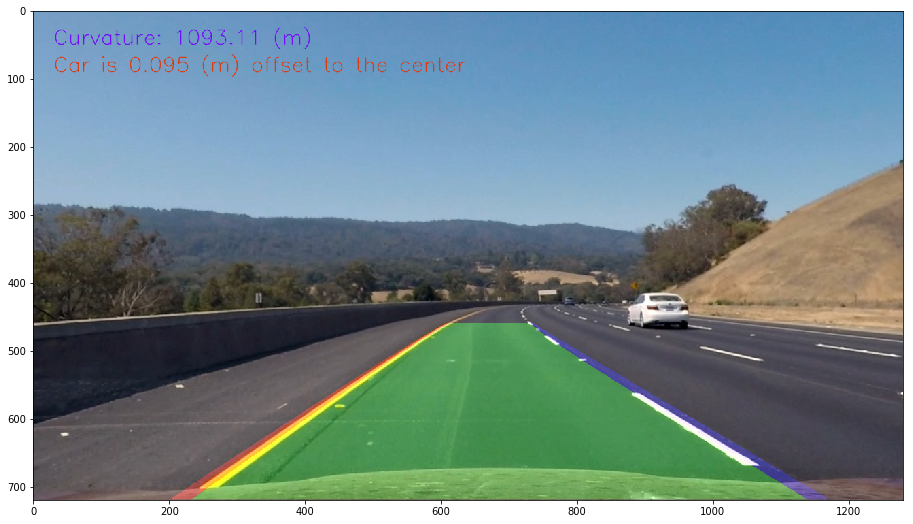

In [16]:
test_img_input = mpimg.imread('test_images/test3.jpg')
left_fit, right_fit = None, None
lines_detected_image = process_image(test_img_input)
plt.figure(figsize=(24,9))
plt.imshow(lines_detected_image)

## Test on Videos

In [17]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
project_output = 'project_lines_detected_final.mp4'
clip = VideoFileClip('project_video.mp4')
left_fit, right_fit = None, None
project_clip = clip.fl_image(process_image)
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_lines_detected_final.mp4
[MoviePy] Writing video project_lines_detected_final.mp4


100%|█████████▉| 1260/1261 [36:34<00:01,  1.75s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_lines_detected_final.mp4 

CPU times: user 38min 4s, sys: 1min 45s, total: 39min 49s
Wall time: 36min 35s
